In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import csv
from PIL import Image
from scipy import ndimage as nd
from deconvwnr import *

In [2]:
WF = tifffile.imread("widefield.tif")
WF.shape

(64, 64)

The following image is generated using the SOFi simulation tool using the parameters \
NA = 1.3 \
Wavelength = 600 nm \
magnification = 100 \
Pixel size = 6.45 um \
These can be used to generate the PSF which can be used in processing the image

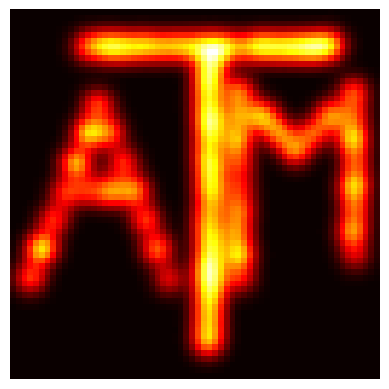

In [3]:
plt.imshow(WF, cmap='hot')
plt.axis("Off")
plt.show()
#plt.imsave('widefield.png',WF,cmap='hot')

The formula corresponding to the widefield image is \
$\langle I(\textbf{r},t)\rangle = \Sigma_{i=1}^N \textit{h}(\textbf{r} - \textbf{r}_i)$ \
\
For intensity correlation microscopy, it is just \
$ICM_2(\textbf{r}) = \Sigma_{i=1}^N \textit{h}(\textbf{r} - \textbf{r}_i)^2$ \
\
But just squaring the intensity doesn't work. It is calculated as \
$ICM_2(\textbf{r}) = G^{(2)}(\textbf{r}) - [G^{(1)}(\textbf{r})]^2$\
And where\
$G^{(1)}(\textbf{r}) \equiv \langle I(\textbf{r},t)\rangle$
\
is Glauber's 1st order correlation function

In [4]:
results = []
with open("2pixel_icm.csv") as csvfile: #this is the file containing the data of 200 frames generated by the SOFI tool
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)
        
results = np.asarray(results)
image = np.zeros([64,64,200])
for i in range(200):
    a = results[:,(i*64):(i*64)+64]
    image[:,:,i] = a
    
image.shape

(64, 64, 200)

In [5]:
af_avg = image.mean(axis=2)

DF = []
for i in range(200):
    df = image[:,:,i] - af_avg
    DF.append(df)
DF = np.asarray(DF)

G2 = np.zeros([64,64])
for i in range(199):
    g = DF[i,:,:] * DF[i+1,:,:]
    G2 += g
G2 = G2/199
ICM = af_avg**2 - G2

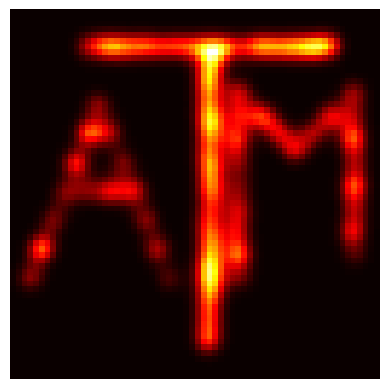

In [6]:
plt.imshow(ICM,cmap='hot')
plt.axis("Off")
plt.show()
plt.imsave("ICM.png",ICM,cmap='hot')

In [7]:
%%capture
k=2
xx = np.linspace(-192,192,1024)
phasedeg = np.array([0,72,144,216,288])
phaserad = np.deg2rad(phasedeg)
sims = []

for i in phaserad:
    a = 1 + np.cos(k*xx + i)
    b = np.tile(a,(1024,1))
    sims.append(b)

for i in range(len(sims)):
    plt.imsave(f'sim{i}.tiff',sims[i])

In [8]:
#for naming variables orderly using the iteration of the for loop itself
for x in range(5):
    globals()['sim%s' % x] = Image.open(f'sim{x}.tiff')

In [9]:
patterns = []

for degree in phasedeg:
    rotated_img0 = nd.rotate(sim0, degree)[619:683,619:683].mean(axis=2)
    rotated_img0[rotated_img0 <= 180] = 0
    rotated_img0[rotated_img0 > 180] = 1
    patterns.append(rotated_img0)
    #plt.imsave(f'sim0{degree}.tiff',rotated_img0)

    rotated_img1 = nd.rotate(sim1, degree)[619:683,619:683].mean(axis=2)
    rotated_img1[rotated_img1 <= 180] = 0
    rotated_img1[rotated_img1 > 180] = 1
    patterns.append(rotated_img1)
    #plt.imsave(f'sim1{degree}.tiff',rotated_img1)
    
    rotated_img2 = nd.rotate(sim2, degree)[619:683,619:683].mean(axis=2)
    rotated_img2[rotated_img2 <= 180] = 0
    rotated_img2[rotated_img2 > 180] = 1
    patterns.append(rotated_img2)
    #plt.imsave(f'sim2{degree}.tiff',rotated_img2)
    
    rotated_img3 = nd.rotate(sim3, degree)[619:683,619:683].mean(axis=2)
    rotated_img3[rotated_img3 <= 180] = 0
    rotated_img3[rotated_img3 > 180] = 1
    patterns.append(rotated_img3)
    #plt.imsave(f'sim3{degree}.tiff',rotated_img3)

    rotated_img4 = nd.rotate(sim4, degree)[619:683,619:683].mean(axis=2)
    rotated_img4[rotated_img4 <= 180] = 0
    rotated_img4[rotated_img4 > 180] = 1
    patterns.append(rotated_img4)
    #plt.imsave(f'sim4{degree}.tiff',rotated_img4)

In [10]:
Iraw = np.array(plt.imread('2 pixel gap.bmp'))[:,:,0]
structured = np.asarray([(i * Iraw) for i in patterns])

In [11]:
for i in range(25):
    data_arr = np.array(structured[i,:,:], np.uint8)  # Convert random_data to NumPy array of type 'uint8'
    pil_image = Image.fromarray(data_arr)  # Convert the NumPy array to PIL image
    pil_image.save(f'sim{i}.bmp')

In [12]:
reconstruct = []

for i in range(25):
    results = []
    with open(f"sim{i}.csv") as csvfile: #this is the file containing the data of 200 frames generated by the SOFI tool
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
        for row in reader: # each row is a list
            results.append(row)
        
    results = np.asarray(results)
    globals()['pat%s' % i] = np.zeros([64,64,200])
    for j in range(200):
        a = results[:,(i*64):(i*64)+64]
        globals()['pat%s' % i][:,:,j] = a
    globals()['pat%s' % i] = globals()['pat%s' % i].mean(axis=2)

KeyboardInterrupt: 

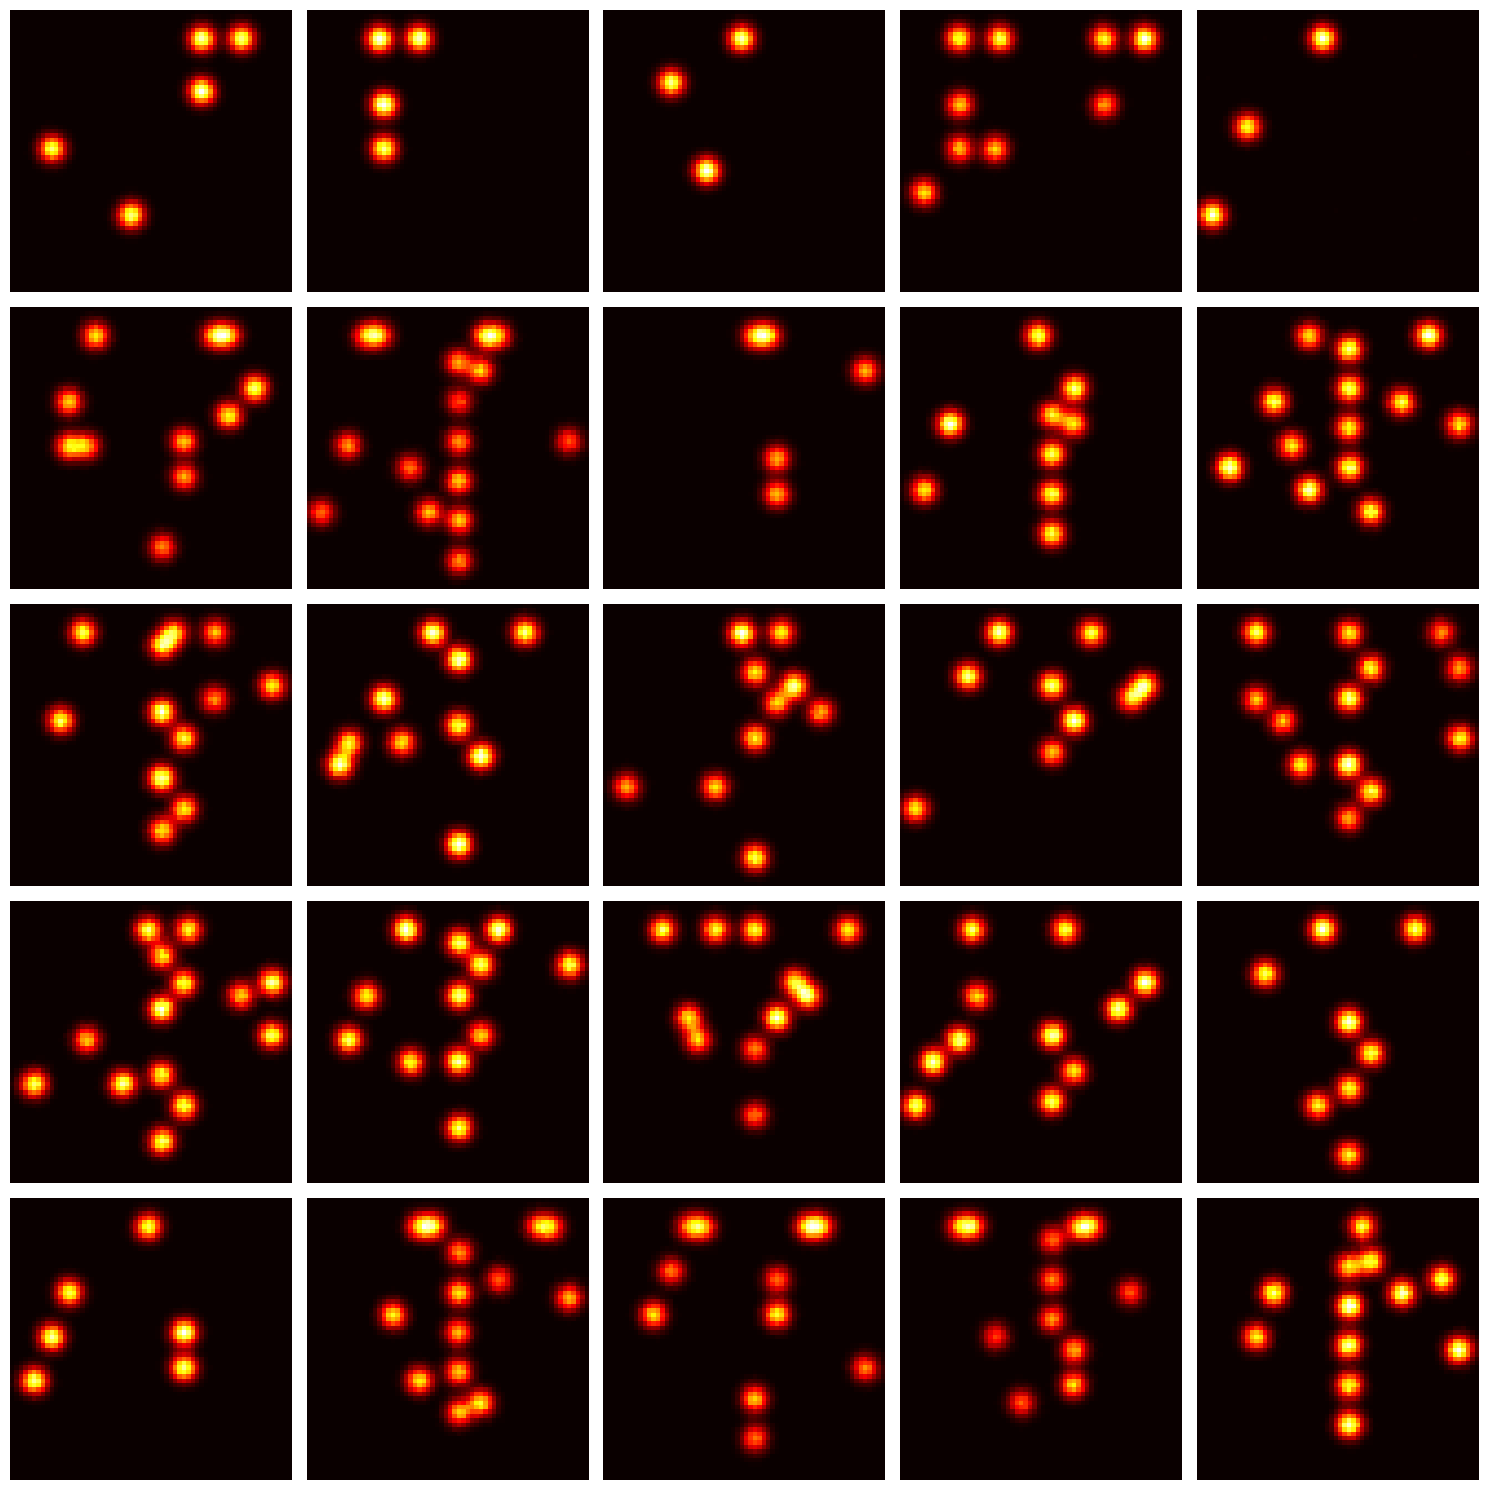

In [ ]:
fig1 = plt.figure(figsize=(15, 15))
rows = 5
columns = 5

for i in range(25):
        reconstruct.append(globals()['pat%s' % i])
        fig1.add_subplot(rows, columns, i+1)
        plt.imshow(globals()['pat%s' % i],cmap='hot')
        plt.axis('off') 

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.tight_layout()
plt.savefig('structured_toprocess.png')

In [ ]:
reconstruct = np.array(reconstruct)
tifffile.imwrite('reconstruct.tif',reconstruct)

In [ ]:
icm_frames = []

for i in range(25):
    results = []
    with open(f"sim{i}.csv") as csvfile: #this is the file containing the data of 200 frames generated by the SOFI tool
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
        for row in reader: # each row is a list
            results.append(row)
        
    results = np.asarray(results)
    globals()['pat%s' % i] = np.zeros([64,64,200])
    for j in range(200):
        a = results[:,(i*64):(i*64)+64]
        globals()['pat%s' % i][:,:,j] = a
    icm_frames.append(globals()['pat%s' % i])

In [ ]:
af_avg = image.mean(axis=2)

DF = []
for i in range(200):
    df = image[:,:,i] - af_avg
    DF.append(df)
DF = np.asarray(DF)

G2 = np.zeros([64,64])
for i in range(199):
    g = DF[i,:,:] * DF[i+1,:,:]
    G2 += g
    
G2 = G2/199
ICM = af_avg**2 - G2

In [ ]:
icm = []
for i in icm_frames:
    af_avg = i.mean(axis=2)

    DF = []
    for j in range(200):
        df = i[:,:,j] - af_avg
        DF.append(df)
    DF = np.asarray(DF)

    G2 = np.zeros([64,64])
    for i in range(199):
        g = DF[i,:,:] * DF[i+1,:,:]
        G2 += g
    G2 = G2/199
    ICM = af_avg**2 - G2
    icm.append(ICM)

In [ ]:
len(icm)

25

In [ ]:
icm = np.asarray(icm)
icm.shape

(25, 64, 64)

In [ ]:
tifffile.imwrite('reconstruct_icm.tif',icm)